In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import pmdarima
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('coin_Dogecoin.csv')
df
# print ('\n Data Types:')
# print (df.dtypes)

SNo      Name Symbol              Date      High       Low      Open  \
0        1  Dogecoin   DOGE  16-12-2013 23:59  0.000866  0.000150  0.000299   
1        2  Dogecoin   DOGE  17-12-2013 23:59  0.000289  0.000116  0.000207   
2        3  Dogecoin   DOGE  18-12-2013 23:59  0.000362  0.000205  0.000267   
3        4  Dogecoin   DOGE  19-12-2013 23:59  0.001520  0.000328  0.000395   
4        5  Dogecoin   DOGE  20-12-2013 23:59  0.001143  0.000662  0.001143   
...    ...       ...    ...               ...       ...       ...       ...   
2755  2756  Dogecoin   DOGE  02-07-2021 23:59  0.247997  0.238848  0.243982   
2756  2757  Dogecoin   DOGE  03-07-2021 23:59  0.250214  0.242454  0.245106   
2757  2758  Dogecoin   DOGE  04-07-2021 23:59  0.252567  0.243425  0.246425   
2758  2759  Dogecoin   DOGE  05-07-2021 23:59  0.246419  0.227838  0.246419   
2759  2760  Dogecoin   DOGE  06-07-2021 23:59  0.241910  0.229842  0.231216   

         Close        Volume     Marketcap  
0     0.000205  0.000000e+00  1.509085e+06  
1     0.000269  0.000000e+00  2.169688e+06  
2     0.000362  0.000000e+00  3.188943e+06  
3     0.001162  0.000000e+00  1.115034e+07  
4     0.000704  0.000000e+00  7.284337e+06  
...        ...           ...           ...  
2755  0.245264  1.321471e+09  3.194925e+10  
2756  0.246411  9.170158e+08  3.210491e+10  
2757  0.246483  9.735115e+08  3.211767e+10  
2758  0.231614  1.267949e+09  3.018344e+10  
2759  0.234422  1.265920e+09  3.055252e+10  

[2760 rows x 10 columns]

In [3]:
# Convert 'Low' column to a time series
ts = df['Low']
# ts.head(50)
ts.head(5)

0    0.000150
1    0.000116
2    0.000205
3    0.000328
4    0.000662
Name: Low, dtype: float64

In [4]:
# ts.tail(30)

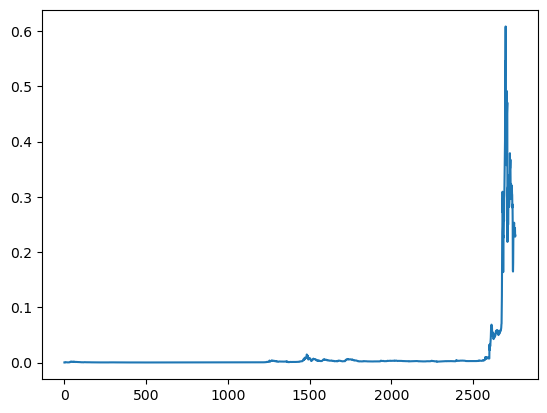

In [5]:
# plotting the converted time series
plt.plot(ts)

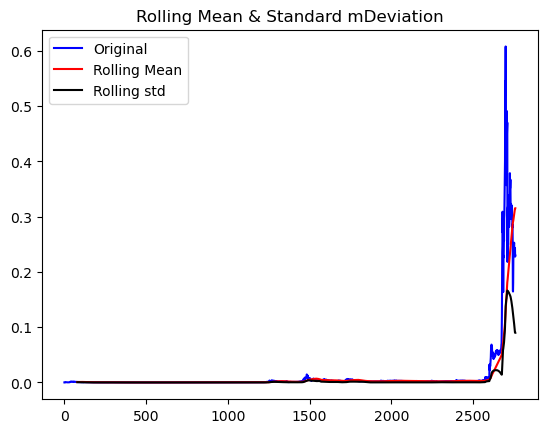

Results of Dickey-Fuller Test:
Test Statistic                   -2.398150
p-value                           0.142259
#Lags Used                       26.000000
Number of Observations Used    2733.000000
Critical Value (1%)              -3.432745
Critical Value (5%)              -2.862598
Critical Value (10%)             -2.567333
dtype: float64


In [6]:
def test_stationarity(timeseries):
    
    #determinig rolling mean and statistics
    rolmean = pd.Series(timeseries).rolling(window=80).mean()
    rolstd = pd.Series(timeseries).rolling(window=80).std()
    #plot rolling mean and statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard mDeviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

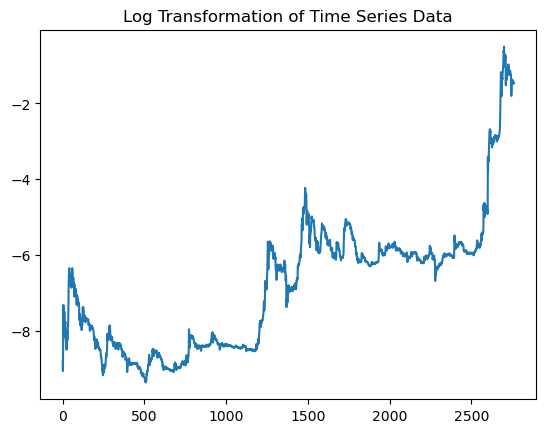

In [7]:
# Logarithmic Transformation of Time Series Data
ts_log = np.log(ts)
plt.plot(ts_log)
plt.title('Log Transformation of Time Series Data')
plt.show()


In [8]:
# Moving Average
moving_avg = ts_log.rolling(85).mean()
plt.plot(ts_log, label='Original Time Series')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.legend()
plt.title('Moving Average of Time Series Data')
plt.show()


In [9]:
# Subtracting Moving Average from Log-transformed Time Series
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(85)

ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(85)


84     0.122937
85    -0.052346
86     0.042195
87     0.153671
88     0.150253
         ...   
164   -0.289163
165   -0.405612
166   -0.414522
167   -0.400217
168   -0.236541
Name: Low, Length: 85, dtype: float64

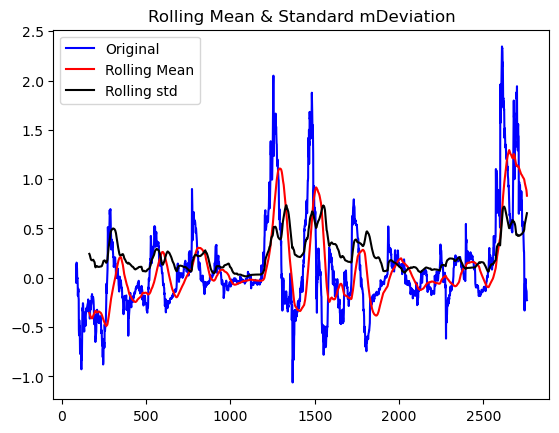

Results of Dickey-Fuller Test:
Test Statistic                   -5.226632
p-value                           0.000008
#Lags Used                       27.000000
Number of Observations Used    2648.000000
Critical Value (1%)              -3.432822
Critical Value (5%)              -2.862632
Critical Value (10%)             -2.567351
dtype: float64


In [10]:
# Testing Stationarity of Time Series after Removing Trend
test_stationarity(ts_log_moving_avg_diff)


In [11]:
# Plotting Exponentially Weighted Moving Average
expwighted_avg = ts_log.ewm(halflife=85, min_periods=0, adjust=True).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.title('Exponentially Weighted Moving Average')
plt.show()


In [12]:
# Subtracting trend-eliminated value from exponentially weighted average
ts_log_ewm_diff = ts_log - expwighted_avg

# Testing stationarity of the differenced series
test_stationarity(ts_log_ewm_diff)


Results of Dickey-Fuller Test:
Test Statistic                   -3.109356
p-value                           0.025868
#Lags Used                       28.000000
Number of Observations Used    2731.000000
Critical Value (1%)              -3.432747
Critical Value (5%)              -2.862599
Critical Value (10%)             -2.567334
dtype: float64


In [13]:
ts_log_diff = ts_log-ts_log.shift()
plt.plot(ts_log_diff)
plt.title('Differenced Time Series')

Text(0.5, 1.0, 'Differenced Time Series')

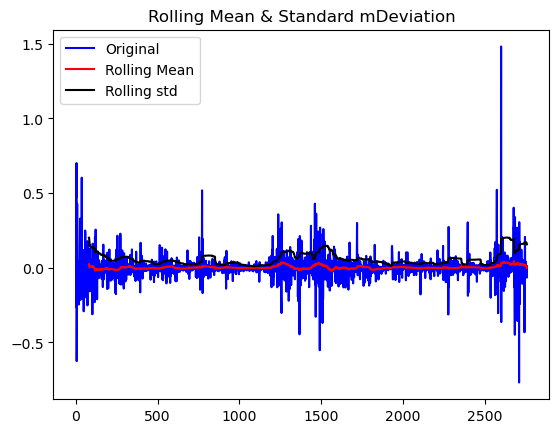

Results of Dickey-Fuller Test:
Test Statistic                -8.749461e+00
p-value                        2.862701e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.731000e+03
Critical Value (1%)           -3.432747e+00
Critical Value (5%)           -2.862599e+00
Critical Value (10%)          -2.567334e+00
dtype: float64


In [14]:
# Drop missing values and test stationarity of the differenced time series
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)


In [116]:
df = pd.read_csv('coin_Dogecoin.csv')


In [117]:
# Perform seasonal decomposition with specified period

df.set_index('Date', inplace=True)
decomposition = seasonal_decompose(df['Close'], model='additive', period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.subplot(411)
plt.plot(df['Volume'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [17]:
# Forecasting a Time Series
# Calculating autocorrelation (ACF) and partial autocorrelation (PACF) functions
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)


In [18]:
# Plotting Autocorrelation Function (ACF)

plt.subplot(121)
plt.plot(lag_acf)  # Plot ACF values
plt.axhline(y=0,linestyle='--',color='black')  # Add horizontal line at y=0
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')  # Add upper confidence interval
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='black')  # Add lower confidence interval
plt.title('Partial Autocorrelation Function', color= 'red', fontsize='20')  # Add title


Text(0.5, 1.0, 'Partial Autocorrelation Function')

In [19]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 2))
results_ARIMA = model.fit()

# Plot original data and fitted values
plt.plot(ts_log_diff, label='Original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='Fitted')
plt.title('ARIMA Fit')
plt.legend()
plt.show()

In [20]:
# Generating Predictions in Original Scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)


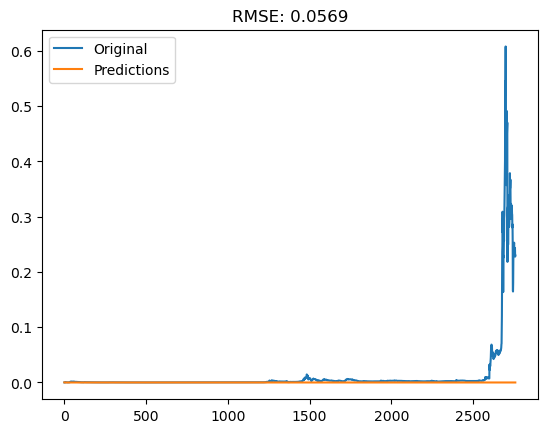

In [21]:
# Convert Predictions to Original Scale and Plot
predictions_ARIMA = np.exp(predictions_ARIMA_log)  # Convert predictions to original scale
plt.plot(ts, label='Original')  # Plot original time series
plt.plot(predictions_ARIMA, label='Predictions')  # Plot predicted values
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))  # Add title with RMSE
plt.legend()  # Add legend
plt.show()  # Show plot


## ->ARIMA is used for modeling and forecasting real-world time series data
## ->simulating ARIMA processes is used for generating synthetic data based on predefined ARIMA specifications for research or testing purposes.

<function matplotlib.pyplot.show(close=None, block=None)>

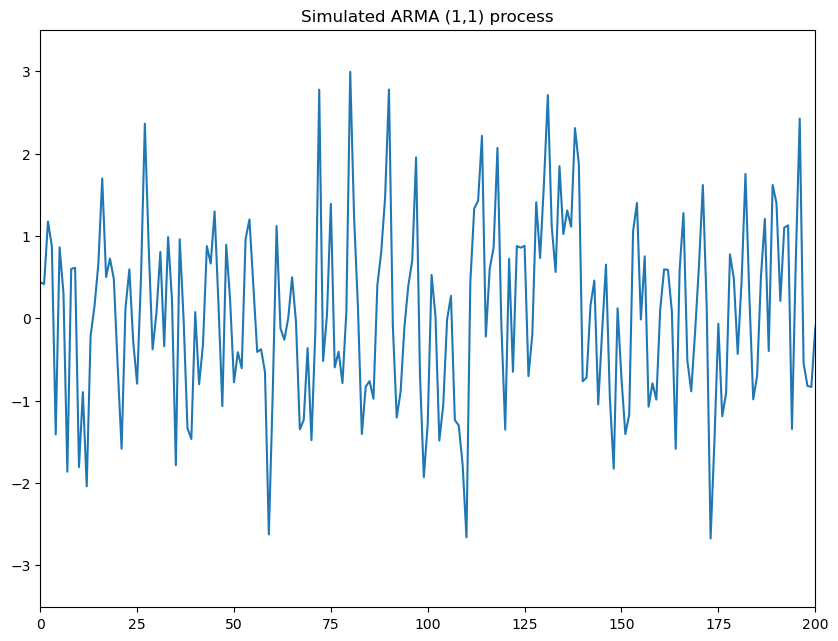

In [22]:
plt.rcParams['figure.figsize'] = [10, 7.5]
##simulate arma (1,1) process
ar1 = np.array([1, 0.33])
ma1 = np.array([1,0.9])
ARMA_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)
#plotting arma
plt.plot(ARMA_1)
plt.title('Simulated ARMA (1,1) process')
plt.xlim([0, 200])
plt.show

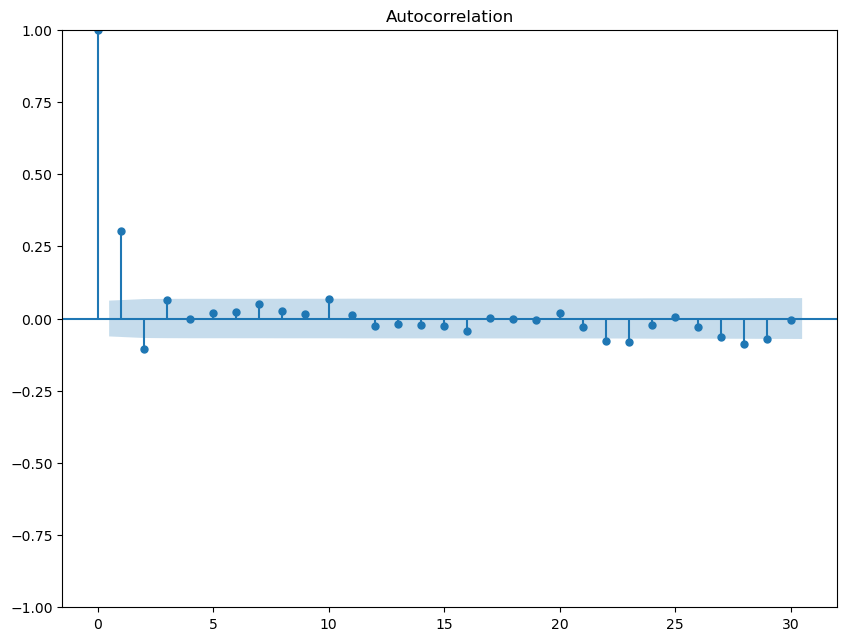

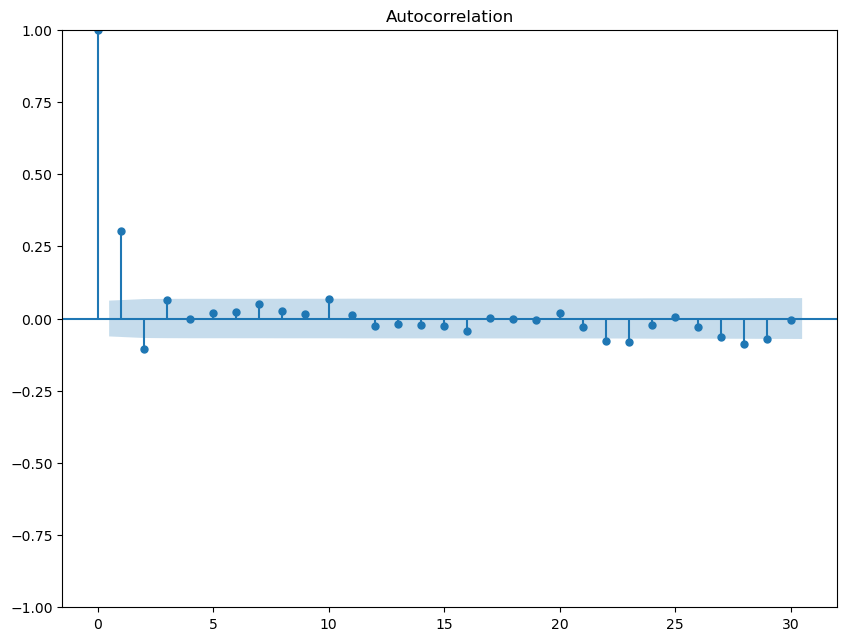

In [23]:
#plotting acf and pcf of arma 
plot_acf(ARMA_1)


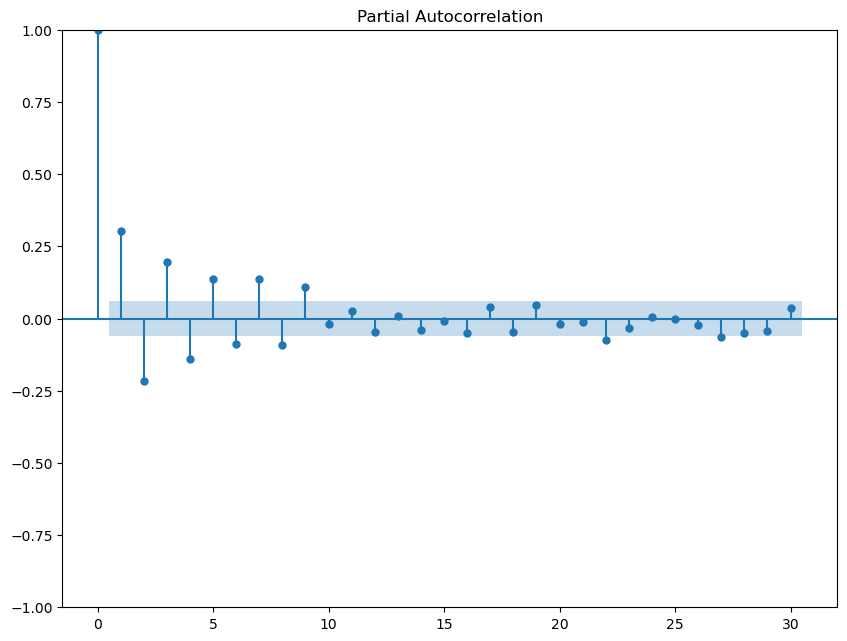

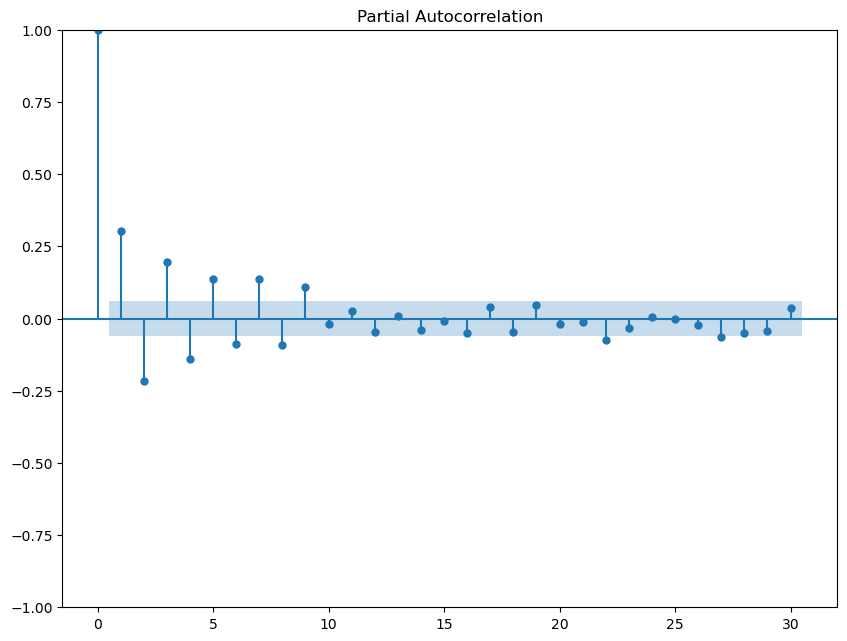

In [24]:
plot_pacf(ARMA_1)

In [25]:

df = pd.DataFrame(df)
df.set_index('Date', inplace=True)

# Verify the contents of the DataFrame and column name
print(df.head())
print(df.info())

# Plot the 'Close' column
df['Close'].plot(figsize=(12, 5))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price over Time')
plt.show()


                  SNo      Name Symbol      High       Low      Open  \
Date                                                                   
16-12-2013 23:59    1  Dogecoin   DOGE  0.000866  0.000150  0.000299   
17-12-2013 23:59    2  Dogecoin   DOGE  0.000289  0.000116  0.000207   
18-12-2013 23:59    3  Dogecoin   DOGE  0.000362  0.000205  0.000267   
19-12-2013 23:59    4  Dogecoin   DOGE  0.001520  0.000328  0.000395   
20-12-2013 23:59    5  Dogecoin   DOGE  0.001143  0.000662  0.001143   

                     Close  Volume     Marketcap  
Date                                              
16-12-2013 23:59  0.000205     0.0  1.509085e+06  
17-12-2013 23:59  0.000269     0.0  2.169688e+06  
18-12-2013 23:59  0.000362     0.0  3.188943e+06  
19-12-2013 23:59  0.001162     0.0  1.115034e+07  
20-12-2013 23:59  0.000704     0.0  7.284337e+06  
<class 'pandas.core.frame.DataFrame'>
Index: 2760 entries, 16-12-2013 23:59 to 06-07-2021 23:59
Data columns (total 9 columns):
 #   Colum

In [26]:
#importing adfuller 
from statsmodels.tsa.stattools import adfuller

def ad_test(df):
    dftest = adfuller(df, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num Of Lags : ",dftest[2])
    print("4. Num Of Observations Used For ADF Rgression and Critical Values Calculations : ",dftest[3])
    print("5. Critical Values :")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    for key, val in dftest[4].items():
         dfoutput['Critical Values (%5)'%key]

In [27]:
#stepwise method
stepwise_fit = auto_arima(df['Close'], trace=True,
                         suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-18296.986, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18046.430, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18090.286, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18080.350, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18048.194, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-18156.423, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18114.000, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-18181.919, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-18290.452, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18093.643, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-18234.443, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18138.199, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-18320.536, Time=1.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-18323.873, Time=1.17 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2760
Model:               SARIMAX(5, 1, 4)   Log Likelihood                9307.346
Date:                Thu, 21 Mar 2024   AIC                         -18594.692
Time:                        14:46:31   BIC                         -18535.466
Sample:                    12-16-2013   HQIC                        -18573.298
                         - 07-06-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2164      0.008     26.263      0.000       0.200       0.233
ar.L2         -0.3525      0.008    -44.715      0.000      -0.368      -0.337
ar.L3          0.3436      0.007     50.046      0.000       0.330       0.357
ar.L4         -0.5341      0.005    -97.867      0.000      -0.545      -0.523
ar.L5         -0.3192      0.003    -96.924      0.000      -0.326      -0.313
ma.L1         -0.3524      0.009    -41.195      0.000      -0.369      -0.336
ma.L2          0.5360      0.009     59.447      0.000       0.518       0.554
ma.L3         -0.3126      0.008    -39.885      0.000      -0.328      -0.297
ma.L4          0.6405      0.006     99.745      0.000       0.628       0.653
sigma2      6.867e-05    2.4e-07    285.553      0.000    6.82e-05    6.91e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):           2998502.11
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):           46559.57   Skew:                             4.40
Prob(H) (two-sided):                  0.00   Kurtosis:                       164.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#test and train
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(2760, 9)
(2730, 9) (30, 9)


In [101]:
df = pd.read_csv('coin_Dogecoin.csv')


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2759
Model:                 ARIMA(1, 0, 5)   Log Likelihood                9219.096
Date:                Thu, 21 Mar 2024   AIC                         -18422.192
Time:                        14:57:27   BIC                         -18374.811
Sample:                    12-17-2013   HQIC                        -18405.076
                         - 07-06-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.645      0.519      -0.000       0.000
ar.L1          0.0323      0.013      2.423      0.015       0.006       0.058
ma.L1         -0.1952      0.013    -14.713      0.0

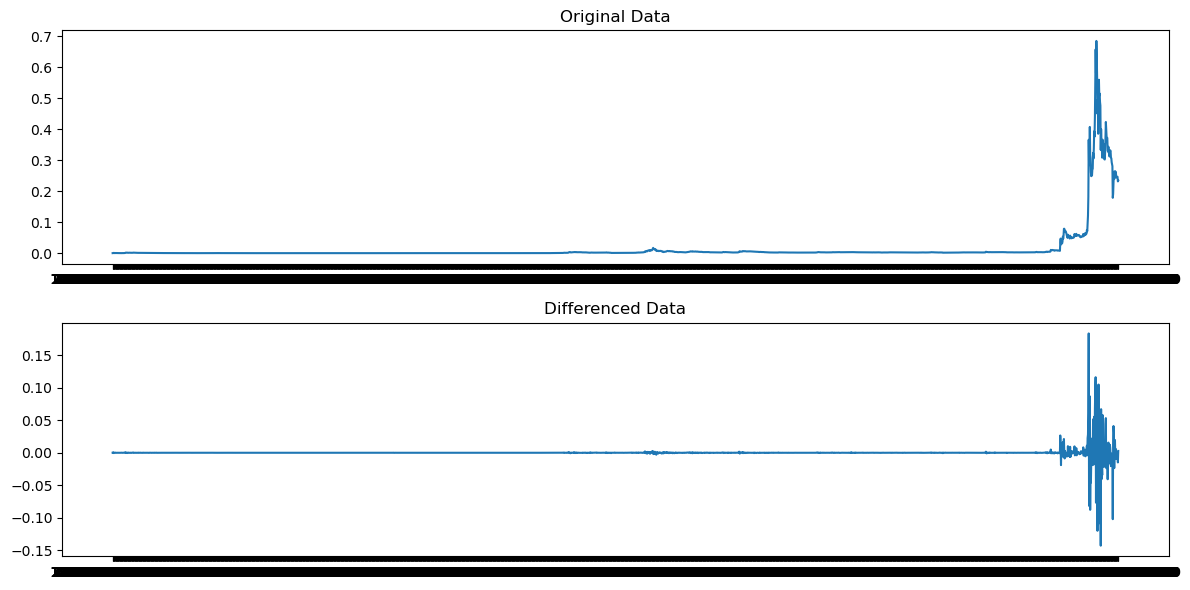

In [102]:
##train results of ARMA model 
train = pd.DataFrame(df)
train.set_index('Date', inplace=True)

# Induce stationarity using differencing
train_diff = train['Close'].diff().dropna()

# Fit ARIMA model
model = ARIMA(train_diff, order=(1, 0, 5))
model_fit = model.fit()

print(model_fit.summary())

# Plot the original data and differenced data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(train['Close'])
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(train_diff)
plt.title('Differenced Data')
plt.tight_layout()
plt.show()


In [99]:
#making predictions in test set
# df = pd.DataFrame(df)
df.set_index('Date', inplace=True)

# Split data into train and test sets
train = df.iloc[:80]  # Replace this with your actual train data
test = df.iloc[80:]   # Replace this with your actual test data

# Fit ARIMA model to the training data
model = ARIMA(train['Close'], order=(1, 0, 5))
model_fit = model.fit()

# Make predictions on the test set
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels')

# Convert the index of predictions to match the test set index
pred.index = test.index

print(pred)


Date
06-03-2014 23:59    0.001065
07-03-2014 23:59    0.001040
08-03-2014 23:59    0.001054
09-03-2014 23:59    0.001035
10-03-2014 23:59    0.001033
                      ...   
02-07-2021 23:59    0.000947
03-07-2021 23:59    0.000947
04-07-2021 23:59    0.000947
05-07-2021 23:59    0.000947
06-07-2021 23:59    0.000947
Name: predicted_mean, Length: 2680, dtype: float64


<Axes: xlabel='Date'>

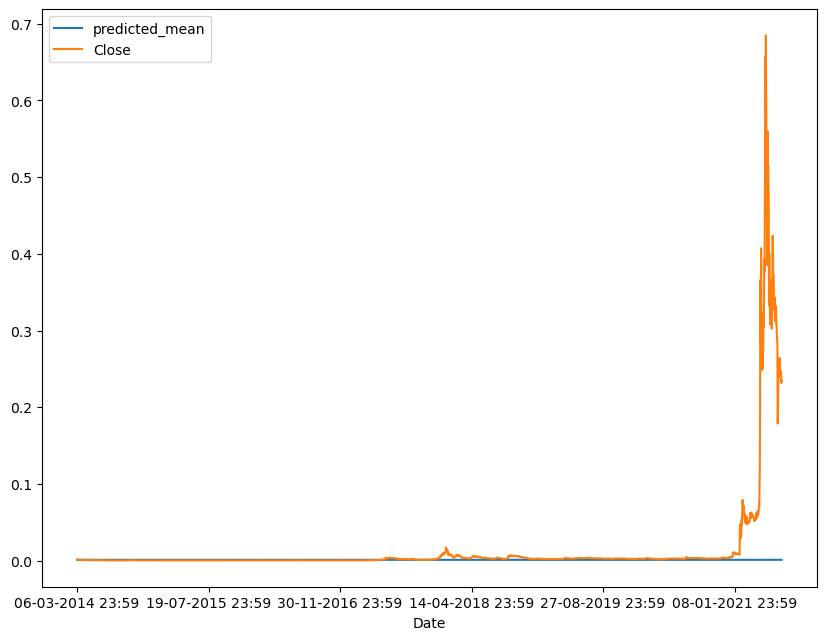

In [91]:
#predicting legend in close dataset
pred.plot(legend=True)
test['Close'].plot(legend=True)

In [92]:
#importing and printing the value of rmse
# from sklearn.metrics import mean_squared_error
# from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Close']))
print(rmse)

0.06479279331020849


In [93]:
# here we are going to see at which date our dataset ends
model2=ARIMA(df['Close'],order=(1,0,5))
model2=model2.fit()
df.tail()

SNo      Name Symbol      High       Low      Open  \
Date                                                                    
02-07-2021 23:59  2756  Dogecoin   DOGE  0.247997  0.238848  0.243982   
03-07-2021 23:59  2757  Dogecoin   DOGE  0.250214  0.242454  0.245106   
04-07-2021 23:59  2758  Dogecoin   DOGE  0.252567  0.243425  0.246425   
05-07-2021 23:59  2759  Dogecoin   DOGE  0.246419  0.227838  0.246419   
06-07-2021 23:59  2760  Dogecoin   DOGE  0.241910  0.229842  0.231216   

                     Close        Volume     Marketcap  
Date                                                    
02-07-2021 23:59  0.245264  1.321471e+09  3.194925e+10  
03-07-2021 23:59  0.246411  9.170158e+08  3.210491e+10  
04-07-2021 23:59  0.246483  9.735115e+08  3.211767e+10  
05-07-2021 23:59  0.231614  1.267949e+09  3.018344e+10  
06-07-2021 23:59  0.234422  1.265920e+09  3.055252e+10

In [94]:
df = pd.read_csv('coin_Dogecoin.csv')


In [95]:
#here we are going to predict next 30 days from the last date of datset we have
# df = pd.DataFrame(df)
df.set_index('Date', inplace=True)

# Fit ARIMA model to the data
model = ARIMA(df['Close'], order=(1, 0, 5))
model_fit = model.fit()

# Generate future dates for prediction (next 30 days from the last date of the dataset)
last_date = df.index[-1]
index_future_dates = pd.date_range(start=last_date, periods=30, freq='D')

# Make predictions for the next 30 days
pred = model_fit.predict(start=len(df), end=len(df) + 29, typ='levels').rename('ARIMA Predictions')
pred.index = index_future_dates

# print(pred)
pred

2021-06-07 23:59:00    0.237132
2021-06-08 23:59:00    0.232173
2021-06-09 23:59:00    0.223921
2021-06-10 23:59:00    0.224397
2021-06-11 23:59:00    0.225248
2021-06-12 23:59:00    0.223751
2021-06-13 23:59:00    0.222264
2021-06-14 23:59:00    0.220789
2021-06-15 23:59:00    0.219325
2021-06-16 23:59:00    0.217871
2021-06-17 23:59:00    0.216429
2021-06-18 23:59:00    0.214997
2021-06-19 23:59:00    0.213575
2021-06-20 23:59:00    0.212164
2021-06-21 23:59:00    0.210764
2021-06-22 23:59:00    0.209374
2021-06-23 23:59:00    0.207994
2021-06-24 23:59:00    0.206625
2021-06-25 23:59:00    0.205266
2021-06-26 23:59:00    0.203916
2021-06-27 23:59:00    0.202577
2021-06-28 23:59:00    0.201248
2021-06-29 23:59:00    0.199929
2021-06-30 23:59:00    0.198619
2021-07-01 23:59:00    0.197319
2021-07-02 23:59:00    0.196029
2021-07-03 23:59:00    0.194748
2021-07-04 23:59:00    0.193477
2021-07-05 23:59:00    0.192215
2021-07-06 23:59:00    0.190963
Freq: D, Name: ARIMA Predictions, dtype:

<Axes: >

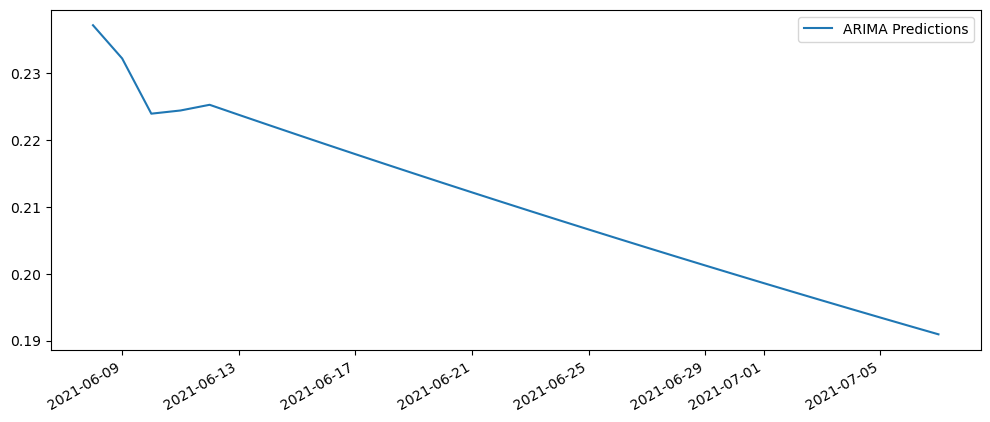

In [96]:
pred.plot(figsize=(12,5),legend=True)